# TRABAJO 1: ENSEMBLE LEARNING | MACHINE LEARNING II
## Feb 2023
--- 

### GRUPO: 6
- Pablo Pérez González-Alberto
- Juan Miguel Ramos Pugnaire
- Andrés Canalejo Oliva
- Pablo Cardenal Real de Asúa

--- 

**IMPORTANTE:**
- Asegúrate, fijando la semilla de los nº aleatorios según proceda, que si se vuelve a ejecutar el cuaderno los resultados son idénticos
- Responde a las preguntas planteadas utilizando instrucciones "print" que permitan leer cómodamente como resultado de la ejecución de la celda el texto explicativo junto a las figuras o tablas a las que haga referencia (mira el ejemplo en la primera gráfica que se representa). También puedes usar markdown para responder.
- No escribas líneas de código muy largas, tienes una regla para ayudarte a no hacerlo
- No cambies la estructura del documento, respeta las secciones que ya existen


---
Importamos todos los paquetes aquí por comodidad

In [1]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.inspection import permutation_importance
from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import BaggingRegressor

from mltools import model_tools as MT
from mltools import classification_tools as CT

c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1. AJUSTE DE LOS MODELOS CON EL DATASET AJU_DATOS_DEM_C3

Se trata de estimar la variable FESTIVO (1: el día es festivo) a partir de las variables disponibles en el dataset que se consideren oportunas. NO se pueden utilizar como variables de entrada: FECHA, DIA ni ANNO. La FECHA es interesante manejarla simplemente como ayuda para entender lo que esté pasando.

Se deben ajustar diferentes modelos, buscando un buen compromiso entre la complejidad y el error en cada uno de ellos. El objetivo es conseguir un buen modelo con una gran capacidad de acierto en el futuro. Modelos que deben crearse, analizando los resultados de cada uno de ellos (errores e importancias de las variables):
- Simple tree
- Bagged  tree
- Random Forest
- Gradient boosting
- Stacking

Carga de datos

In [2]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju = pd.read_csv('AJU_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_aju.FECHA = pd.to_datetime(df_aju.FECHA, format='%d/%m/%Y') 
s=df_aju.loc[:,'FECHA']
df_aju['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_aju['ANNO']
del df_aju['DIA']

print('Tamaño de df_orig con los datos cargados:', df_aju.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_aju

Tamaño de df_orig con los datos cargados: (2879, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


,FECHA,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,...,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,FESTIVO,TMIN,TMAX
0,2014-01-01,0.040942,0.038985,0.036382,0.034416,0.033409,0.033420,0.034054,0.034229,0.035889,...,0.055197,0.054185,0.051063,0.046240,0.041000,1,3,1,12.3,20.2
1,2014-01-02,0.033950,0.030996,0.029517,0.028966,0.029165,0.030150,0.032944,0.036510,0.041196,...,0.055820,0.054451,0.051482,0.046145,0.040880,1,4,0,12.0,20.1
2,2014-01-03,0.035463,0.032112,0.030292,0.029521,0.029450,0.030515,0.033188,0.036656,0.041052,...,0.055230,0.053520,0.050286,0.045412,0.040025,1,5,0,13.2,21.0
3,2014-01-04,0.035959,0.032772,0.031034,0.030178,0.030135,0.030782,0.032598,0.034982,0.039299,...,0.053757,0.052620,0.049973,0.044970,0.040386,1,6,0,14.4,23.4
4,2014-01-05,0.037506,0.034148,0.031878,0.031126,0.030930,0.031604,0.033066,0.034803,0.038758,...,0.052902,0.051481,0.049655,0.045730,0.040905,1,7,0,12.8,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,2021-12-27,0.033180,0.031299,0.030173,0.029493,0.029649,0.030814,0.033925,0.037837,0.042098,...,0.051685,0.050563,0.047267,0.042237,0.037797,12,1,0,16.1,23.0
2875,2021-12-28,0.033823,0.031731,0.030385,0.029950,0.030017,0.031203,0.034708,0.038432,0.042645,...,0.051867,0.050971,0.047718,0.042585,0.037774,12,2,0,16.6,22.7
2876,2021-12-29,0.034475,0.032198,0.030902,0.030441,0.030384,0.031487,0.034454,0.038381,0.042850,...,0.052136,0.050604,0.046788,0.042033,0.037595,12,3,0,14.3,21.3
2877,2021-12-30,0.034345,0.031919,0.030524,0.029991,0.030087,0.031286,0.034384,0.038574,0.042778,...,0.052092,0.050993,0.047587,0.042807,0.038252,12,4,0,13.4,26.4


Visión general de las series

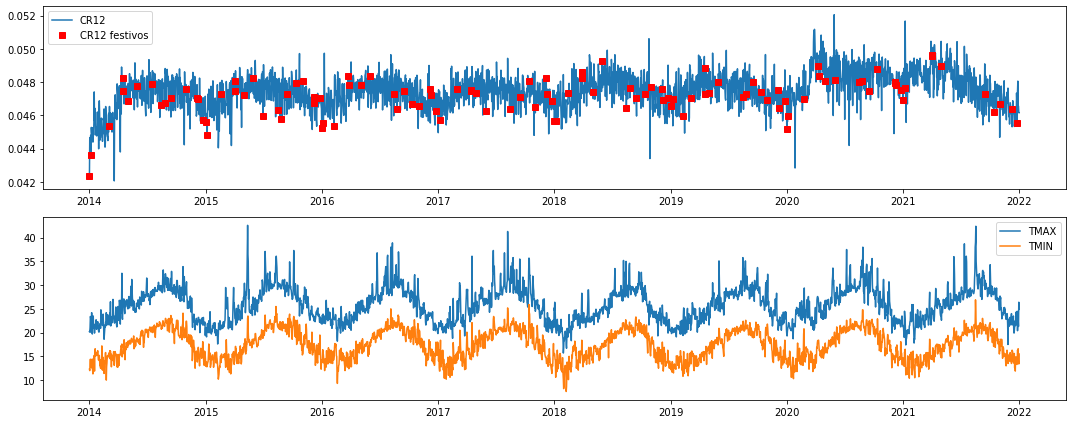

Se observa que el nº de festivos (115) es claramente inferior al nº de laborables (2764)
En concreto, el porcentaje de festivos en el conjunto de ajuste es 3.99444251476207 %


In [3]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
fig = plt.figure(1, figsize=(15,6))
ax1 = plt.subplot(2,1,1)

ind_festivo = df_aju.FESTIVO == 1

plt.plot(df_aju.FECHA, df_aju.CR12, label='CR12')

plt.plot(df_aju.FECHA[ind_festivo], df_aju.CR12[ind_festivo], 'sr', label='CR12 festivos')
plt.legend()

plt.subplot(2,1,2,sharex= ax1)
plt.plot(df_aju.FECHA, df_aju.TMAX, label='TMAX')
plt.plot(df_aju.FECHA, df_aju.TMIN, label='TMIN')
plt.tight_layout()
plt.legend()

plt.show()

num_festivos = np.count_nonzero(df_aju.FESTIVO)
num_laborables = df_aju.shape[0] - num_festivos
print(f'Se observa que el nº de festivos ({num_festivos}) es claramente inferior al nº de laborables ({num_laborables})')
print(f'En concreto, el porcentaje de festivos en el conjunto de ajuste es {100*num_festivos /  df_aju.shape[0]} %')
# fig.savefig('figura1.pdf')

---
### 1.1 Análisis exploratorio básico del problema

- Incluye un análisis que te permita comprender la naturaleza del problema, cómo son las variables de entrada, su interrelación, así como su relación con la variable de salida
- Comenta todo lo que parezca relevante para el tema tratado, incluyendo todas las gráficas que consideres oportunas
- Estudia cómo se reparten los festivos según el día de la semana y los meses

In [4]:
#sns.pairplot(df_aju, hue='FESTIVO')

In [5]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

#print('\nInfo variables:')
#print(df_aju.describe())
#
#g = sns.PairGrid(df_aju, hue="FESTIVO")
#g.map_diag(sns.histplot)
##g.map_offdiag(sns.scatterplot)
#g.map_upper(sns.scatterplot)
#g.map_lower(sns.kdeplot)
#g.add_legend()

#### Prepara los conjuntos de entrenamiento y test

- Divide los datos disponibles de ajuste (df_aju) en dos conjuntos diferentes (TR:80% y TS: 20%). TS lo deberías de utilizar para validar la calidad de los diferentes modelos que se creen.
- Recuerda fijar una semilla para garantizar que la separación es reproducible

In [6]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
df_aju.FESTIVO = df_aju.FESTIVO.astype('category')
# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos
# Define input and output matrices
INPUTS = ['CR00', 'CR01', 'CR02', 'CR03', 'CR04', 'CR05', 'CR06', 'CR07',
       'CR08', 'CR09', 'CR10', 'CR11', 'CR12', 'CR13', 'CR14', 'CR15', 'CR16',
       'CR17', 'CR18', 'CR19', 'CR20', 'CR21', 'CR22', 'CR23', 'MES', 'DIASEM', 
       'TMIN', 'TMAX']
OUTPUT = 'FESTIVO'
X = df_aju[INPUTS]
y = df_aju[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

#### 1.2. Ajusta un modelo de clasificación sencillo que sea robusto y que pueda servir de referencia de comparación con otros modelos más complejos.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables

In [7]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
## Inputs of the model
INPUTS_DT = INPUTS

# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005), # Minimum entropy to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

# param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split

pipe = Pipeline(steps=[('DT', DecisionTreeClassifier(criterion='gini',  # impurity measure
                                                     random_state=150))]) # For replication
                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
900 fits failed out of a total of 8100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeClassifier(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='accuracy')

In [8]:
# Show the best grid parameter combination found by CV
tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 150,
 'splitter': 'best'}

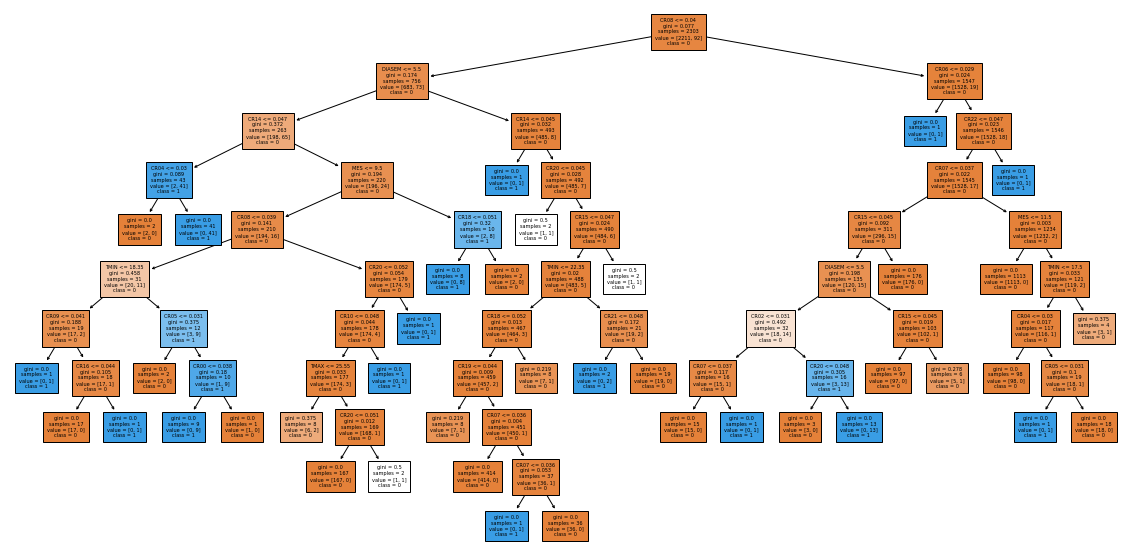

In [9]:
## Plot the decision tree model (use figsize and fontsize for getting the best view)
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'],
          feature_names= INPUTS_DT,
          class_names= [str(s) for s in y_train.unique()],
          fontsize=5, filled=True)
plt.show()

In [10]:
# Easy reading of the tree
print(export_text(tree_fit.best_estimator_['DT'], feature_names= INPUTS_DT))

|--- CR08 <= 0.04
|   |--- DIASEM <= 5.50
|   |   |--- CR14 <= 0.05
|   |   |   |--- CR04 <= 0.03
|   |   |   |   |--- class: 0
|   |   |   |--- CR04 >  0.03
|   |   |   |   |--- class: 1
|   |   |--- CR14 >  0.05
|   |   |   |--- MES <= 9.50
|   |   |   |   |--- CR08 <= 0.04
|   |   |   |   |   |--- TMIN <= 18.35
|   |   |   |   |   |   |--- CR09 <= 0.04
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- CR09 >  0.04
|   |   |   |   |   |   |   |--- CR16 <= 0.04
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- CR16 >  0.04
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- TMIN >  18.35
|   |   |   |   |   |   |--- CR05 <= 0.03
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- CR05 >  0.03
|   |   |   |   |   |   |   |--- CR00 <= 0.04
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- CR00 >  0.04
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- CR08

In [11]:
# model predictions in training (TR) and test (TS) sets
clf = tree_fit.best_estimator_['DT']
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

                         TR        TS
Accuracy           0.996092  0.967014
Balanced accuracy  0.951087  0.774471

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 83    9
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.95
Mcnemar's Test P-Value: 0.0
Sensitivity: 1.0
Specificity: 0.9
Precision: 1.0
Recall: 0.9
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 0.95
F1 Score: 0.95
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 13  10
         0  9 544

Accuracy: 0.97
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.23
Kappa: 0.56
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.98
Specificity: 0.57
Precision: 0.59
Recall: 0.57
Prevalence: 0.96
Detection Rate: 0.94
Detection prevalence: 0.96
Balanced accuracy: 0.77
F1 Score: 0.58
Positive label: 1


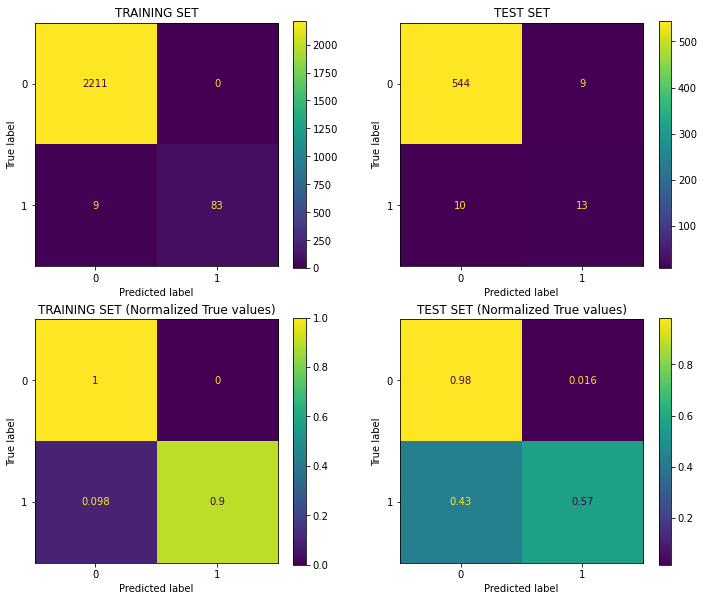

In [12]:
fig = plt.figure(figsize=(12, 10))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

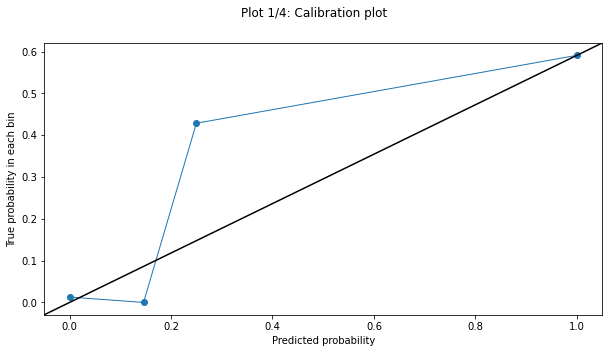

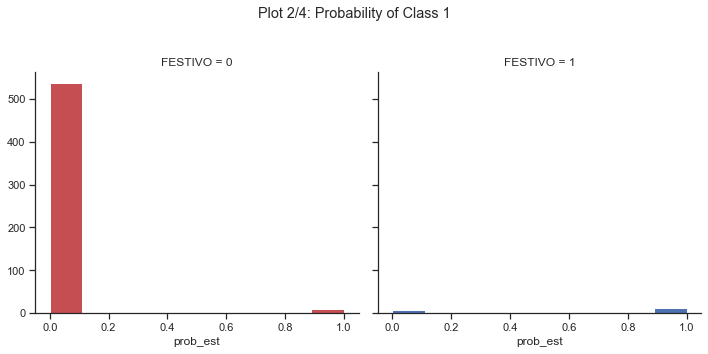

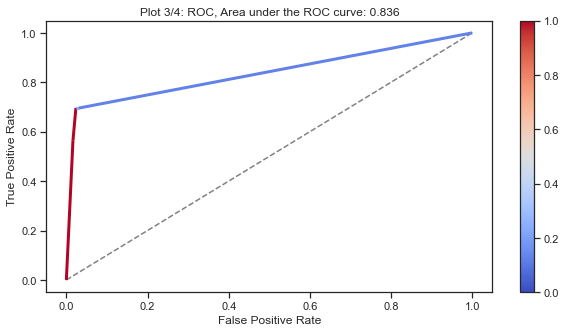

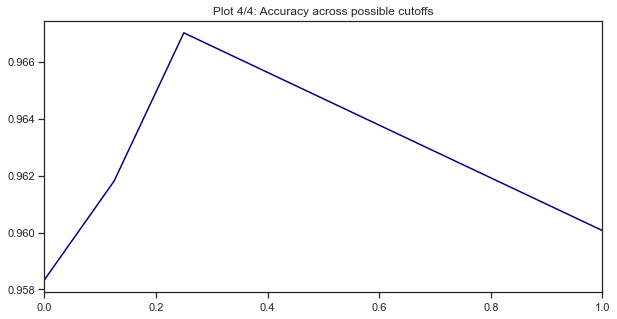

In [13]:
CT.plotClassPerformance(y_test, clf.predict_proba(X_test[INPUTS_DT]), selClass=1)

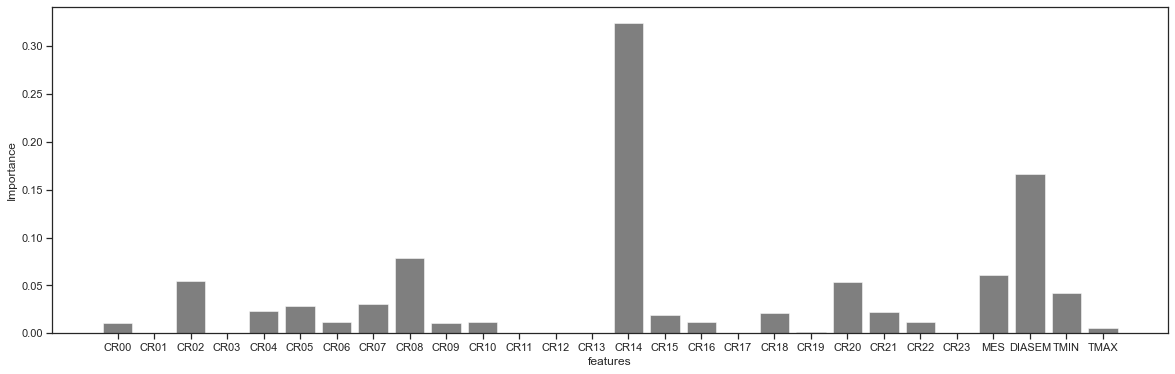

In [14]:
## Plot the variable importance of each feature
plt.figure(figsize=(20, 6))
bar_width = 0.35
plt.bar(INPUTS_DT, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.show()

#### 1.3. Ajusta un bagged tree para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [15]:
number_estimators = 50
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeClassifier( criterion='gini',  # impurity measure
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=1, # Minimum number of obs in a terminal node
                                                            random_state=150))])

bag_class_estim = BaggingClassifier(base_estimator=base_estimator,
                                    n_estimators=number_estimators,
                                    random_state=150)

# fit the bagged trees
INPUTS_BT = INPUTS                 
bag_class_estim.fit(X_train[INPUTS_BT], y_train)

BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                  DecisionTreeClassifier(random_state=150))]),
                  n_estimators=50, random_state=150)

In [16]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# find optim nº of trees in the ensemble
param = {'BT__n_estimators': range(20, 150, 5)} # Number of trees to aggregate

pipe =  Pipeline(steps=[('BT', 
                            BaggingClassifier(base_estimator=base_estimator,
                                              random_state=150))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
bt_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_BT = INPUTS  
bt_fit.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                                                          DecisionTreeClassifier(random_state=150))]),
                                                          random_state=150))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)},
             scoring='accuracy')

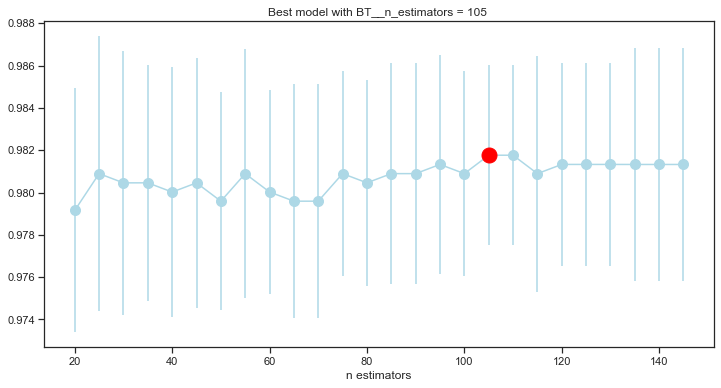

In [17]:
MT.plotModelGridError(bt_fit)

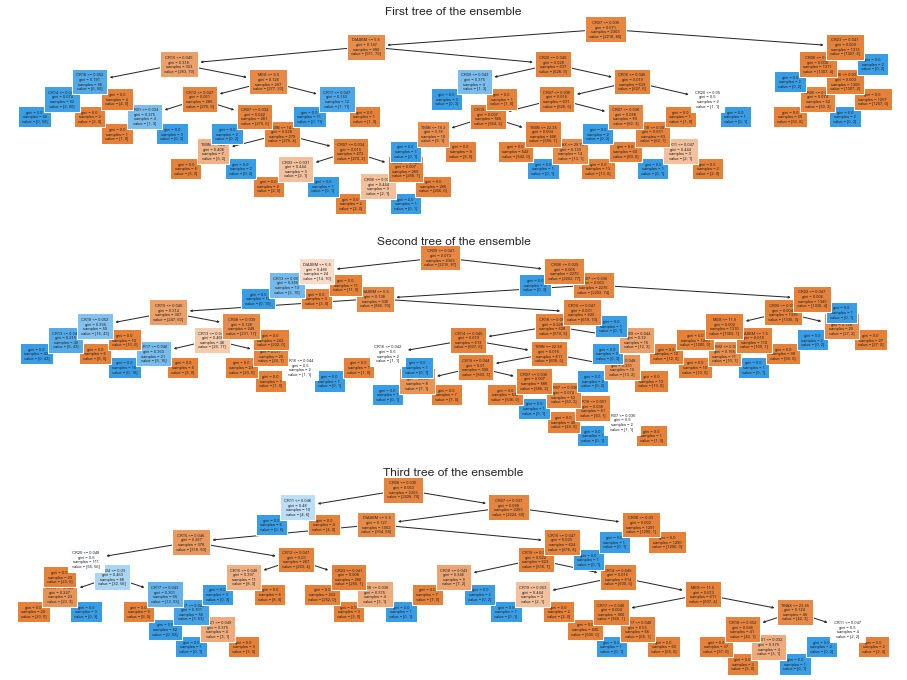

In [18]:
## Plot first trees of the ensemble
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plot_tree(bt_fit.best_estimator_['BT'].estimators_[0]['DT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'First tree of the ensemble')
plt.subplot(3,1,2)
plot_tree(bt_fit.best_estimator_['BT'].estimators_[1]['DT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'Second tree of the ensemble')
plt.subplot(3,1,3)
plot_tree(bt_fit.best_estimator_['BT'].estimators_[2]['DT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'Third tree of the ensemble')
plt.show()

In [19]:
# model predictions in training (TR) and test (TS) sets
clf = bt_fit
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

                    TR        TS
Accuracy           1.0  0.984375
Balanced accuracy  1.0  0.846018

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 92    0
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 16   7
         0  2 551

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.77
Mcnemar's Test P-Value: 0.18
Sensitivity: 1.0
Specificity: 0.7
Precision: 0.89
Recall: 0.7
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.97
Balanced accuracy: 0.85
F1 Score: 0.78
Positive label: 1


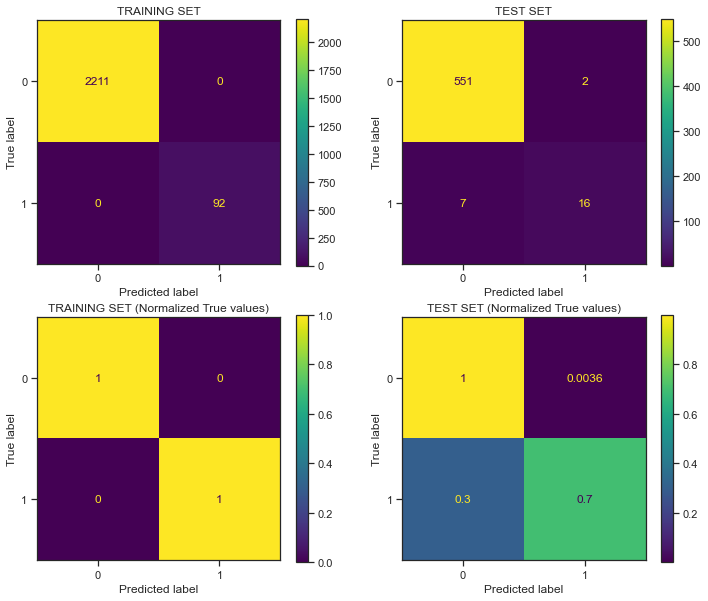

In [20]:
fig = plt.figure(figsize=(12,10))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

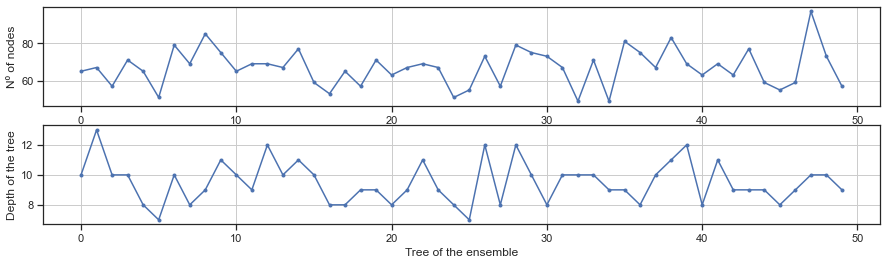

In [21]:
# number of nodes in each tree of the ensemble
node_count_trees = [t['DT'].tree_.node_count for t in bag_class_estim.estimators_]

# number of nodes in each tree of the ensemble
depth_trees = [t['DT'].tree_.max_depth for t in bag_class_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees, '.-')
plt.ylabel('Nº of nodes')                       
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

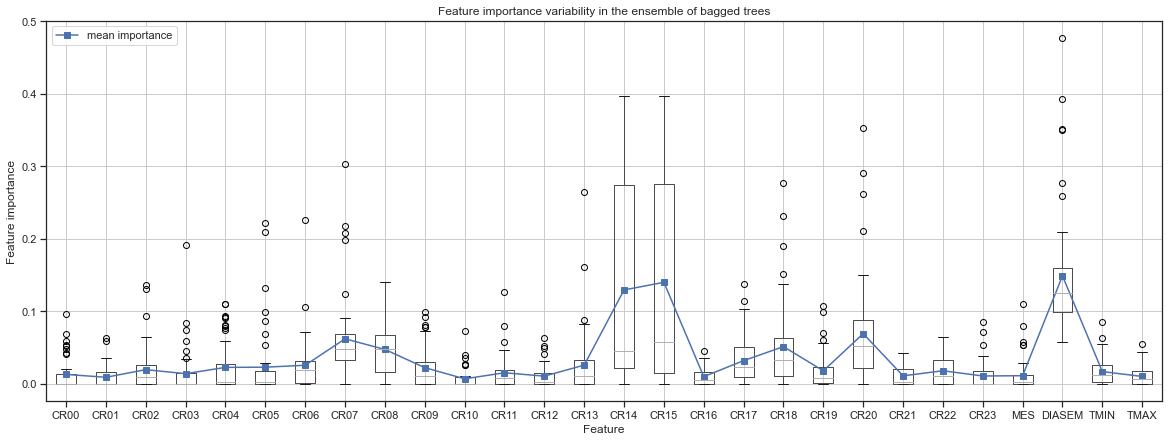

In [22]:
# feature importances of each tree in the ensemble
feature_importances_trees = [t['DT'].feature_importances_ for t in bag_class_estim.estimators_]

# global view of feature importances
dfimp =  pd.DataFrame(list(feature_importances_trees), columns=INPUTS_BT)
dfimp.boxplot(figsize=(20, 7))
plt.plot(np.arange(len(INPUTS_BT))+1, dfimp.mean(),'s-', label ='mean importance')
plt.ylabel('Feature importance') 
plt.xlabel('Feature') 
plt.title('Feature importance variability in the ensemble of bagged trees')
plt.legend()
plt.show()

#### 1.4. Ajusta un random forest para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [23]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Convert output variable to categorical
df_aju.FESTIVO = df_aju.FESTIVO.astype('category')

In [24]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Define input and output matrices
INPUTS = ['CR00', 'CR01', 'CR02', 'CR03', 'CR04', 'CR05', 'CR06', 'CR07',
       'CR08', 'CR09', 'CR10', 'CR11', 'CR12', 'CR13', 'CR14', 'CR15', 'CR16',
       'CR17', 'CR18', 'CR19', 'CR20', 'CR21', 'CR22', 'CR23', 'MES', 'DIASEM', 
       'TMIN', 'TMAX']
OUTPUT = 'FESTIVO'
X = df_aju[INPUTS]
y = df_aju[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

#### 1.4.1. Ajustamos Random Forest optimizado utilizando GridSearch

In [25]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# find optim nº of trees in the ensemble and max_features
param = {'RF__max_features': range(1, 6, 1), # Number number of features to consider when looking for the best split
         'RF__n_estimators': range(20, 150, 5)} # Number of trees in the forest

pipe =  Pipeline(steps=[('RF', 
                            RandomForestClassifier(
                                        criterion='gini',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0)
                        )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_RF = INPUTS  
rf_fit.fit(X_train[INPUTS_RF], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'RF__max_features': range(1, 6),
                         'RF__n_estimators': range(20, 150, 5)},
             scoring='accuracy')

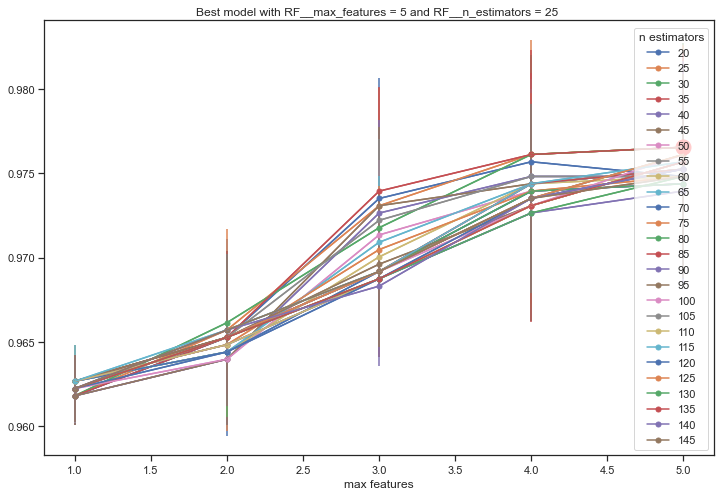

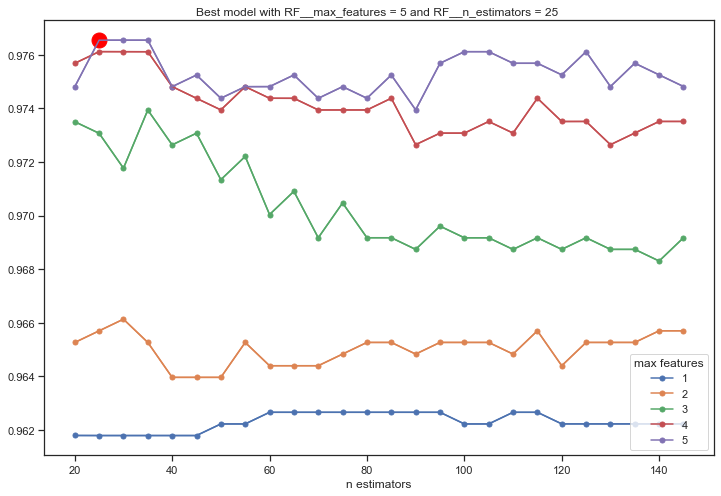

In [26]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

MT.plotModelGridError(rf_fit)

#### 1.4.2. Analizamos los errores en Train y Test

In [27]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# model predictions in training (TR) and test (TS) sets
clf = rf_fit
y_train_pred = clf.predict(X_train[INPUTS_RF]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_RF]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  
                      columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

                         TR        TS
Accuracy           0.999566  0.979167
Balanced accuracy  0.994565  0.759965

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 91    1
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 0.99
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 0.99
Precision: 1.0
Recall: 0.99
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 0.99
F1 Score: 0.99
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 12  11
         0  1 552

Accuracy: 0.98
No Information Rate: 0.94
P-Value [Acc > NIR]: 0.01
Kappa: 0.66
Mcnemar's Test P-Value: 0.01
Sensitivity: 1.0
Specificity: 0.52
Precision: 0.92
Recall: 0.52
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.98
Balanced accuracy: 0.76
F1 Score: 0.67
Positive label: 1


#### 1.4.3. Analizamos la matriz de confusión

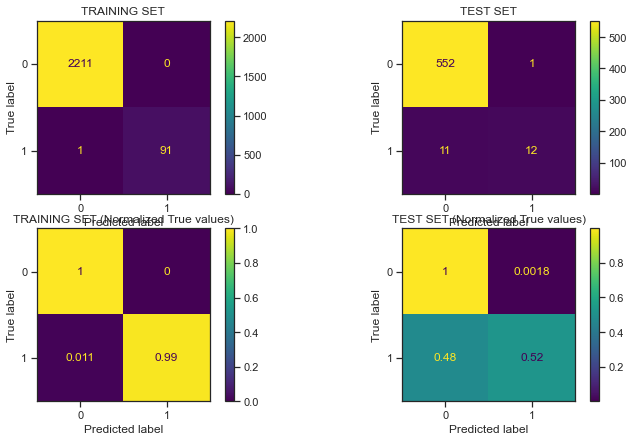

In [28]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

#### 1.4.4. Analizamos la importancia de las variables del modelo

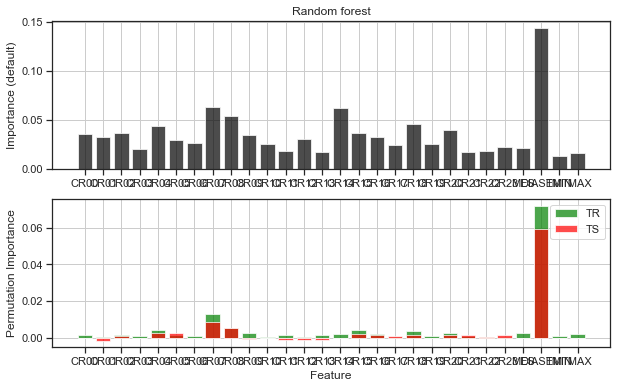

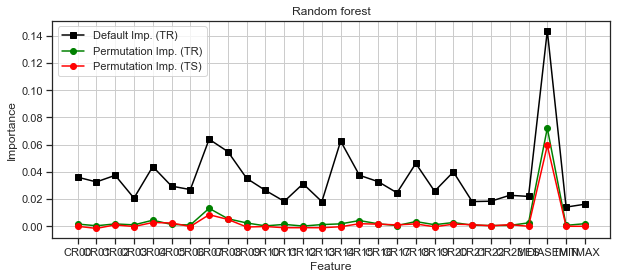

In [29]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

RF_class_estim = rf_fit.best_estimator_['RF']

## Feature importance evaluation using "Permutation Importance" (training and test)
importances_tr_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_train[INPUTS_RF], y_train,
                                    n_repeats=10,
                                    random_state=0)

importances_ts_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_test[INPUTS_RF], y_test,
                                    n_repeats=10,
                                    random_state=0)
 
## Plot importances

# Plot the variable importance of each feature given by feature_importances_ attribute
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.bar(INPUTS_RF, RF_class_estim.feature_importances_, color='black', alpha=0.7)
plt.ylabel('Importance (default)')
plt.title('Random forest')
plt.grid()

plt.subplot(2,1,2)
plt.bar(INPUTS_RF, importances_tr_RF_class_estim.importances_mean, color='green', alpha=0.7, label='TR')
plt.bar(INPUTS_RF, importances_ts_RF_class_estim.importances_mean, color='red', alpha=0.7, label='TS')
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.legend()
plt.grid()
plt.show()

# Plot the variable importances of each feature (all together)
plt.figure(figsize=(10, 4))

plt.plot(INPUTS_RF, RF_class_estim.feature_importances_, 's-',  color='black', label='Default Imp. (TR)')
plt.plot(INPUTS_RF, importances_tr_RF_class_estim.importances_mean, 'o-', color='green', label='Permutation Imp. (TR)')
plt.plot(INPUTS_RF, importances_ts_RF_class_estim.importances_mean, 'o-', color='red', label='Permutation Imp. (TS)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random forest')
plt.legend()
plt.grid()
plt.show()

#### 1.5. Ajusta un gradient boosting para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

#### 1.5.1. Ajustamos Gradient Boosting optimizado utilizando GridSearch

In [30]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Define the pipeline structure with GradientBoostingClassifier model
pipe = Pipeline([('GB', GradientBoostingClassifier())])

# Define the hyperparameters to evaluate
param_grid = {'GB__n_estimators': [100, 500, 1000],   # Number of trees in the forest
              'GB__learning_rate': [0.01, 0.1, 1],    # Learning rate (shrinkage)
              'GB__max_depth': [1, 2, 3],             # Maximum depth of the individual regression estimators
              'GB__max_features': ['sqrt', 'log2'],   # Number of features to consider when looking for the best split
              'GB__loss': ['log_loss', 'exponential'] # Loss function to be optimized
             }

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=pipe, # Model structure to use
                           param_grid=param_grid, # Defined grid to search in
                           cv=10, # Number of cross-validation folds
                           scoring='accuracy', # Scoring metric
                           n_jobs=-1 # Number of parallel jobs to run. -1 means using all processors.
                          )

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()


Best Hyperparameters: {'GB__learning_rate': 0.1, 'GB__loss': 'exponential', 'GB__max_depth': 3, 'GB__max_features': 'sqrt', 'GB__n_estimators': 500}
Best Score: 0.9874082439299829


In [31]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

GB_class_estim = grid_search.best_estimator_['GB']

In [32]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# fit
INPUTS_GB = INPUTS                
GB_class_estim.fit(X_train[INPUTS_GB], y_train)

GradientBoostingClassifier(loss='exponential', max_features='sqrt',
                           n_estimators=500)

#### 1.5.2. Analizamos los errores en Train y Test

In [33]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# model predictions in training (TR) and test (TS) sets
clf = GB_class_estim
y_train_pred = clf.predict(X_train[INPUTS_GB]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_GB]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  
                      columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

                    TR        TS
Accuracy           1.0  0.982639
Balanced accuracy  1.0  0.824279

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 92    0
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 15   8
         0  2 551

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.74
Mcnemar's Test P-Value: 0.11
Sensitivity: 1.0
Specificity: 0.65
Precision: 0.88
Recall: 0.65
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.97
Balanced accuracy: 0.82
F1 Score: 0.75
Positive label: 1


#### 1.5.3. Analizamos la matriz de confusión

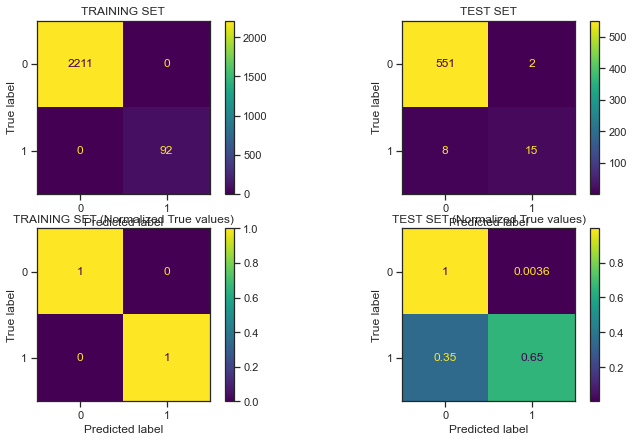

In [34]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

#### 1.5.4. Analizamos la importancia de las variables del modelo

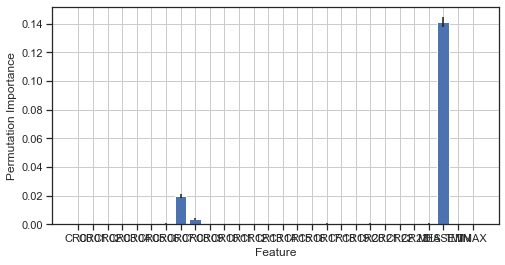

In [35]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

importances_bag_class_estim = permutation_importance(GB_class_estim, 
                                    X_train[INPUTS_GB], y_train,
                                    n_repeats=10,
                                    random_state=0)

fig = plt.figure(2, figsize=(8, 4)) 
plt.bar(INPUTS_GB, importances_bag_class_estim.importances_mean, yerr=importances_bag_class_estim.importances_std)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.grid()
plt.show()

#### 1.6. Utiliza staking con tus mejores tres modelos para intentar mejorar la soluciones obtenidas.
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación

In [41]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# DT #
param_tree = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005), # Minimum entropy to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

pipe_tree = Pipeline(steps=[('DT', DecisionTreeClassifier(criterion='gini',  # impurity measure
                                                     random_state=150))]) # For replication

nFolds_tree = 10

# RF #
param_RF = {'RF__max_features': range(1, 6, 1), # Number number of features to consider when looking for the best split
         'RF__n_estimators': range(20, 150, 5)} # Number of trees in the forest

pipe_RF =  Pipeline(steps=[('RF', 
                            RandomForestClassifier(
                                        criterion='gini',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0)
                        )])

nFolds_RF = 10

# GridSearchCV(estimator=pipe_RF, # Structure of the model to use
#                        param_grid=param_RF, # Defined grid to search in
#                        n_jobs=-1, # Number of cores to use (parallelize)
#                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
#                        cv=nFolds_RF) # Number of Folds 

# BT #
base_estimator_BT =  Pipeline(steps=[('DT', 
                                    DecisionTreeClassifier( criterion='gini',  # impurity measure
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=1, # Minimum number of obs in a terminal node
                                                            random_state=150))])

param_BT = {'BT__n_estimators': range(20, 150, 5)}

pipe_BT = Pipeline(steps=[('BT', 
                            BaggingClassifier(base_estimator=base_estimator_BT,
                                              random_state=150))])

nFolds_BT = 10

# GB #
pipe_GB = Pipeline([('GB', GradientBoostingClassifier())])

param_GB = {'GB__n_estimators': [100, 500, 1000],   # Number of trees in the forest
              'GB__learning_rate': [0.01, 0.1, 1],    # Learning rate (shrinkage)
              'GB__max_depth': [1, 2, 3],             # Maximum depth of the individual regression estimators
              'GB__max_features': ['sqrt', 'log2'],   # Number of features to consider when looking for the best split
              'GB__loss': ['log_loss', 'exponential'] # Loss function to be optimized
             }

nFolds_GB = 10


## set of estimators to be stacked
estimators = [
    ('gradboost', make_pipeline(
        GridSearchCV(estimator=pipe_GB, # Model structure to use
                        param_grid=param_GB, # Defined grid to search in
                        cv=nFolds_GB, # Number of cross-validation folds
                        scoring='accuracy', # Scoring metric
                        n_jobs=-1)) # Number of parallel jobs to run. -1 means using all processors.
    ),
    ('bagtree', make_pipeline(
        GridSearchCV(estimator=pipe_BT, # Structure of the model to use
                       param_grid=param_BT, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds_BT)) # Number of Folds 
    ),
    ('clatree', make_pipeline(
                GridSearchCV(estimator=pipe_tree, # Structure of the model to use
                       param_grid=param_tree, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds_tree)) # Number of Folds 
    )
]

estimators

[('gradboost',
  Pipeline(steps=[('gridsearchcv',
                   GridSearchCV(cv=10,
                                estimator=Pipeline(steps=[('GB',
                                                           GradientBoostingClassifier())]),
                                n_jobs=-1,
                                param_grid={'GB__learning_rate': [0.01, 0.1, 1],
                                            'GB__loss': ['log_loss',
                                                         'exponential'],
                                            'GB__max_depth': [1, 2, 3],
                                            'GB__max_features': ['sqrt', 'log2'],
                                            'GB__n_estimators': [100, 500, 1000]},
                                scoring='accuracy'))])),
 ('bagtree',
  Pipeline(steps=[('gridsearchcv',
                   GridSearchCV(cv=10,
                                estimator=Pipeline(steps=[('BT',
                                          

In [42]:
weights = [0.33, 0.33, 0.34] # pesos de los 3 modelos
stacked_cla = VotingClassifier(estimators = estimators, weights = weights)
stacked_cla = stacked_cla.fit(X_train, y_train)
stacked_cla.get_params()

c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()


{'estimators': [('gradboost',
   Pipeline(steps=[('gridsearchcv',
                    GridSearchCV(cv=10,
                                 estimator=Pipeline(steps=[('GB',
                                                            GradientBoostingClassifier())]),
                                 n_jobs=-1,
                                 param_grid={'GB__learning_rate': [0.01, 0.1, 1],
                                             'GB__loss': ['log_loss',
                                                          'exponential'],
                                             'GB__max_depth': [1, 2, 3],
                                             'GB__max_features': ['sqrt', 'log2'],
                                             'GB__n_estimators': [100, 500, 1000]},
                                 scoring='accuracy'))])),
  ('bagtree',
   Pipeline(steps=[('gridsearchcv',
                    GridSearchCV(cv=10,
                                 estimator=Pipeline(steps=[('BT',
           

- Errores en train y test

In [43]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# model predictions in training (TR) and test (TS) sets
y_train_stack = stacked_cla.predict(X_train)
y_test_stack = stacked_cla.predict(X_test)

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_stack)
acc_ts = metrics.accuracy_score(y_test,y_test_stack)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_stack)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_stack)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  
                      columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_stack, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_stack, labels=[1,0])

                    TR        TS
Accuracy           1.0  0.984375
Balanced accuracy  1.0  0.846018

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 92    0
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 16   7
         0  2 551

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.77
Mcnemar's Test P-Value: 0.18
Sensitivity: 1.0
Specificity: 0.7
Precision: 0.89
Recall: 0.7
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.97
Balanced accuracy: 0.85
F1 Score: 0.78
Positive label: 1


- Matrices de confusión

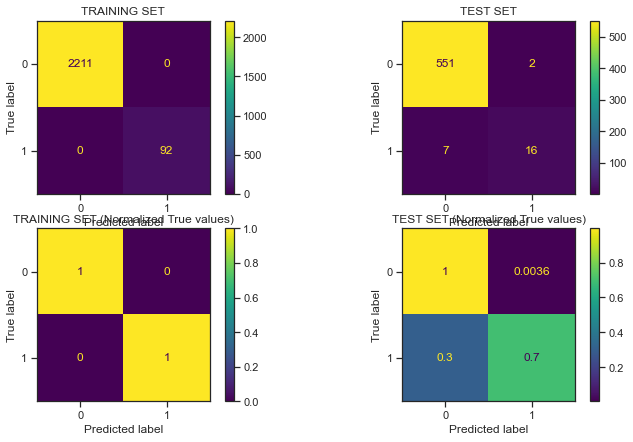

In [44]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(stacked_cla, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(stacked_cla, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(stacked_cla, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(stacked_cla, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

- Capacidad de generalización

In [45]:
# we use the same set of models to be stacked

stacked_genreg = StackingClassifier(
    estimators = estimators,
    final_estimator=RandomForestClassifier(n_estimators=20, random_state=999)
)

stacked_genreg = stacked_genreg.fit(X_train, y_train)
stacked_genreg

c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\juanm\miniconda3\envs\ml\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()


StackingClassifier(estimators=[('gradboost',
                                Pipeline(steps=[('gridsearchcv',
                                                 GridSearchCV(cv=10,
                                                              estimator=Pipeline(steps=[('GB',
                                                                                         GradientBoostingClassifier())]),
                                                              n_jobs=-1,
                                                              param_grid={'GB__learning_rate': [0.01,
                                                                                                0.1,
                                                                                                1],
                                                                          'GB__loss': ['log_loss',
                                                                                       'exponential'],
                          

In [46]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# model predictions in training (TR) and test (TS) sets
y_train_stack_gen = stacked_genreg.predict(X_train)
y_test_stack_gen = stacked_genreg.predict(X_test)

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_stack_gen)
acc_ts = metrics.accuracy_score(y_test,y_test_stack_gen)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_stack_gen)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_stack_gen)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  
                      columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_stack_gen, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_stack_gen, labels=[1,0])

                    TR        TS
Accuracy           1.0  0.980903
Balanced accuracy  1.0  0.865044

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 92    0
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 17   6
         0  5 548

Accuracy: 0.98
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 0.75
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.99
Specificity: 0.74
Precision: 0.77
Recall: 0.74
Prevalence: 0.96
Detection Rate: 0.95
Detection prevalence: 0.96
Balanced accuracy: 0.87
F1 Score: 0.76
Positive label: 1


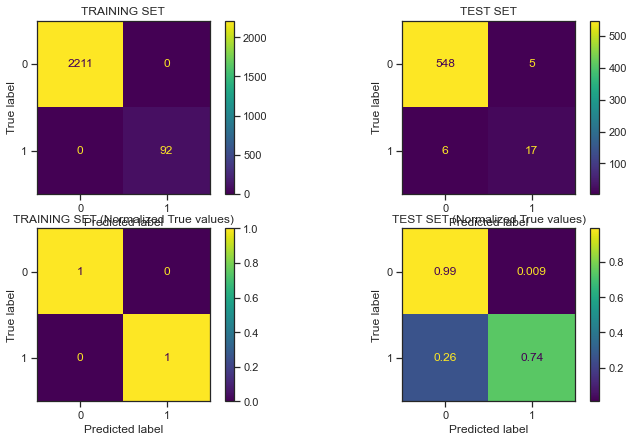

In [47]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(stacked_genreg, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(stacked_genreg, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(stacked_genreg, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(stacked_genreg, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

#### 1.7. Crea un número de variables reducido que contengan la información recogida en las variables CR00 a CR23 y crea un árbol sencillo basado en estas variables.
- El conjunto de variables creado tienen que ser una combinación lineal de CR00, ..., CR23
- Optimiza la complejidad del árbol
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables, explicando el significado físico de las variables más importantes
- Compara los errores en TR y TS y la lógica del modelo con el creado anteriormente en el apartado 1.2.


In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.8 Compara todos los modelos creados en términos de complejidad, interpretabilidad y errores
- Discute el posible impacto que tiene en los modelos el que existan menos festivos que laborables
- Compara la complejidad en términos de nº de parámetros y estructura del modelo, variables utilizadas, importancia de las mismas
- Compara la capacidad de generalización de los modelos utilizando TS y las diferencias en las matrices de confusión
- Estudia la tasa de fallos de los modelos dependiendo del día de la semana
- Indica qué modelo o modelos son los más prometedores para poner en producción, justificando la selección

In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


---
### 2. VALIDACIÓN FINAL DE LOS MODELOS CON EL DATASET VAL_DATOS_DEM_C3

Se correpondería como si los todos los modelos creados anteriormente se ponen en producción el 1 enero de 2022 y se tienen estimando la festividad durante todo el año para ver qué tal funcionan.

Recuerda, no se debería ver ningún resultado sobre este dataset hasta haber completado todos los apartados anteriores.

Carga datos de validación

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_val = pd.read_csv('VAL_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_val.FECHA = pd.to_datetime(df_val.FECHA, format='%d/%m/%Y') 
s=df_val.loc[:,'FECHA']
df_val['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_val['ANNO']
del df_val['DIA']

print('Tamaño de df_val con los datos cargados:', df_val.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
print(df_val)

#### 2.1. Compara los errores obtenidos en validación con los observados previamente en ajuste/test
- Una vez terminados todos los ajustes de los modelos en el apartado 1.1., ejecuta los mismos para estimar si los días de 2022 son festivos o no (conjunto df_val)
- Muestra los resultados de clasificación obtenidos en el nuevo dataset (accuray y tablas de confusión de cada modelo)
- Discute si los errores obtenidos son coherentes con lo que se esperaba como resultado de los análisis previos para estimar la capacidad de generalización de cada uno de los modelos

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 2.2. Análisis de los días peor clasificados
- Indica en una tabla la lista de los días que se han clasificado incorrectamente por cada uno de los modelos considerados
- Comenta las posibles diferencias y semejanzas, intentando buscar una justificación de por qué ha ocurrido el error de clasificación
- Muestra gráficamente los perfiles de 24 horas de los 3 días más difíciles de clasificar para los modelos, comparándolos con lo esperado según el día de la semana correspondiente

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
